# c
 Use OpenAI Gym to create a trained reinforcement learning model for
the cart and pole problem (CartPole-v1).
https://gymnasium.farama.org/environments/classic_control/cart_pole/
Alter the structure so the motion to the right is 50% more aggressive than moving
to the left (ie: velocity to the right is faster by 50%). Record the video of this and
submit the edited code and recording.
Now implement the Frozen Lake scenario (https://gymnasium.farama.org/environments/
toy_text/frozen_lake/) and adjust the environment to work on a randomly gen-
erated 8x8 map. Compare the training performance for this map against a similar
8x8 map that has a random chance (2%) of the agent randomly dying of cold

# Cartpole

In [1]:

import numpy as np
import gymnasium as gym

import torch

import matplotlib.pyplot as plt
import seaborn as sns

class CartPolePolicyNN(torch.nn.Module):
    def __init__(self):
        super(CartPolePolicyNN, self).__init__()
        self.fc1 = torch.nn.Linear(4, 16)
        self.fc2 = torch.nn.Linear(16, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, 2)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

test_model = CartPolePolicyNN()
test_input = torch.randn(1, 4)
test_output = test_model(test_input.float().unsqueeze(0))
print(test_output)




tensor([[[1., 1.]]], grad_fn=<SoftmaxBackward0>)


In [2]:
class CartPoleAgent(object):
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = CartPolePolicyNN().to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        probs = self.model(state)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [3]:
test_total_iterations = 100

testEnv = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'),
                               video_folder="./videos",
                               episode_trigger=lambda x: x == test_total_iterations - 1)

testAgent = CartPoleAgent()

/home/kf7mxe/anaconda3/envs/reinforcement-learning/lib/python3.8/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/kf7mxe/School/2023/Inteligence Robotics/my-inteligence-robotics-repo/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Iteration: 500, Score: 28
Iteration: 1000, Score: 299
Iteration: 1500, Score: 193
Iteration: 2000, Score: 69
Iteration: 2500, Score: 948
Iteration: 3000, Score: 31
Iteration: 3500, Score: 213
Iteration: 4000, Score: 200
Iteration: 4500, Score: 254
Moviepy - Building video /home/kf7mxe/School/2023/Inteligence Robotics/my-inteligence-robotics-repo/videos/non_aggressive_right-episode-4999.mp4.
Moviepy - Writing video /home/kf7mxe/School/2023/Inteligence Robotics/my-inteligence-robotics-repo/videos/non_aggressive_right-episode-4999.mp4



Moviepy - Done !
Moviepy - video ready /home/kf7mxe/School/2023/Inteligence Robotics/my-inteligence-robotics-repo/videos/non_aggressive_right-episode-4999.mp4
Iteration: 5000, Score: 203


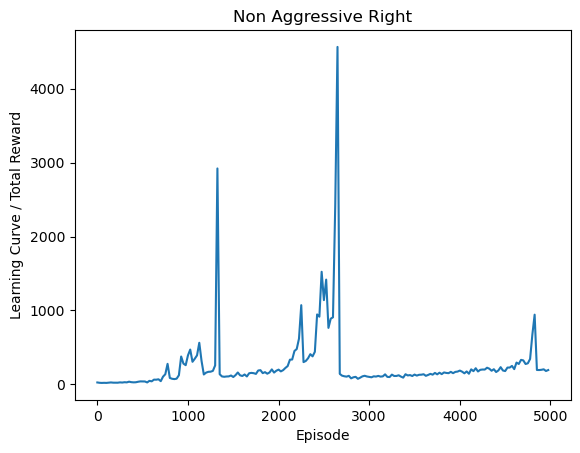

/home/kf7mxe/anaconda3/envs/reinforcement-learning/lib/python3.8/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/kf7mxe/School/2023/Inteligence Robotics/my-inteligence-robotics-repo/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/kf7mxe/anaconda3/envs/reinforcement-learning/lib/python3.8/site-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Iteration: 500, Score: 50
Iteration: 1000, Score: 66
Iteration: 1500, Score: 76
Iteration: 2000, Score: 122
Iteration: 2500, Score: 104
Iteration: 3000, Score: 197
Iteration: 3500, Score: 323
Iteration: 4000, Score: 14
Iteration: 4500, Score: 172
Moviepy - Building video /home/kf7mxe/School/2023/Inteligence Robotics/my-inteligence-robotics-repo/videos/Aggressive_right-episode-4999.mp4.
Moviepy - Writing video /home/kf7mxe/School/2023/Inteligence Robotics/my-inteligence-robotics-repo/videos/Aggressive_right-episode-4999.mp4



Moviepy - Done !
Moviepy - video ready /home/kf7mxe/School/2023/Inteligence Robotics/my-inteligence-robotics-repo/videos/Aggressive_right-episode-4999.mp4
Iteration: 5000, Score: 292


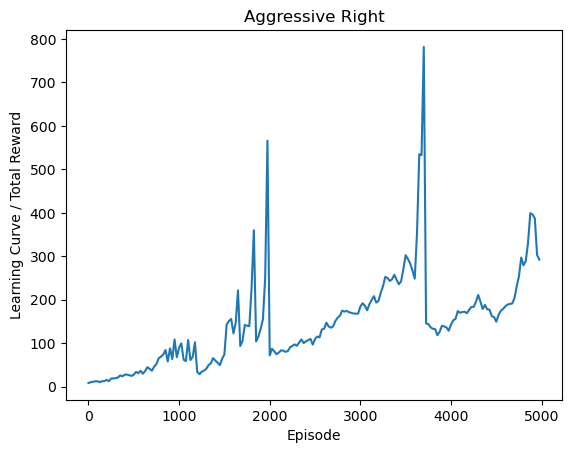

<Figure size 640x480 with 0 Axes>

In [4]:

def trainCartPoleAgent(aggressive_right_mode = False):
    agent = CartPoleAgent()
    learning = []

    for iteration in range(1, total_iterations+1):
        steps = 0
        done = False
        state = env.reset()
        state = state[0]

        cumulative_reward = 0
        action_probabilities = []

        while not done:
            steps += 1
            
            
            action, action_prob = agent.act(state)
            action_probabilities.append(action_prob)

            if aggressive_right_mode:
                if action == 1:
                    env.step(action)

            state, reward, done, *_ = env.step(action)

            cumulative_reward += reward

        policy_loss = [-log_prob * cumulative_reward for log_prob in action_probabilities]
        policy_loss = torch.cat(policy_loss).sum()

        agent.optimizer.zero_grad()
        policy_loss.backward()
        agent.optimizer.step()

        learning.append(steps)
        if iteration % logging_interval == 0:
            print("Iteration: {}, Score: {}".format(iteration, steps))
    x = np.arange(1, len(learning),25)
    y = np. add.reduceat(learning,x) / 25

    sns.lineplot(x=x, y=y)
    plt.xlabel("Episode")
    plt.ylabel("Learning Curve / Total Reward")
    if aggressive_right_mode:
        plt.title("Aggressive Right")
    else:
        plt.title("Non Aggressive Right")
    plt.show()
    if aggressive_right_mode:
        plt.savefig("Aggressive_right.png")
    else:
        plt.savefig("Non_Aggressive_right.png")
    


total_iterations = 5000
logging_interval = 500
env = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'),
                               video_folder="./videos",
                               name_prefix="non_aggressive_right",
                               episode_trigger=lambda x: x == total_iterations - 1)

trainCartPoleAgent(aggressive_right_mode = False)
env = gym.wrappers.RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'),
                               video_folder="./videos",
                               name_prefix="Aggressive_right",
                               episode_trigger=lambda x: x == total_iterations - 1)
trainCartPoleAgent(aggressive_right_mode = True)



# Frozen lake

In [5]:
class FrozenLakePolicyNN(torch.nn.Module):
    def __init__(self):
        super(FrozenLakePolicyNN, self).__init__()
        self.fc1 = torch.nn.Linear(1, 8)
        self.fc2 = torch.nn.Linear(8, 16)
        self.fc3 = torch.nn.Linear(16, 8)
        self.fc4 = torch.nn.Linear(8, 4)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

test_model = CartPolePolicyNN()
test_input = torch.randn(1, 4)
test_output = test_model(test_input.float().unsqueeze(0))
print(test_output)



tensor([[[1., 1.]]], grad_fn=<SoftmaxBackward0>)


In [6]:
class FrozenLakeAgent(object):
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = FrozenLakePolicyNN().to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def act(self, state):
        state = torch.FloatTensor([state])
        probs = self.model(state)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

/home/kf7mxe/anaconda3/envs/reinforcement-learning/lib/python3.8/site-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /home/kf7mxe/School/2023/Inteligence Robotics/my-inteligence-robotics-repo/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Iteration: 1000, Score: 50
Iteration: 2000, Score: 51
Iteration: 3000, Score: 36
Iteration: 4000, Score: 9
Iteration: 5000, Score: 9
Iteration: 6000, Score: 9
Iteration: 7000, Score: 27
Iteration: 8000, Score: 31
Iteration: 9000, Score: 10
Iteration: 10000, Score: 8
Iteration: 11000, Score: 27
Iteration: 12000, Score: 16
Iteration: 13000, Score: 88
Iteration: 14000, Score: 17
Iteration: 15000, Score: 44
Iteration: 16000, Score: 21
Iteration: 17000, Score: 30
Iteration: 18000, Score: 25
Iteration: 19000, Score: 23
Iteration: 20000, Score: 22
Iteration: 21000, Score: 28
Iteration: 22000, Score: 36
Iteration: 23000, Score: 10
Iteration: 24000, Score: 20
Iteration: 25000, Score: 25
Iteration: 26000, Score: 12
Iteration: 27000, Score: 9
Iteration: 28000, Score: 21
Iteration: 29000, Score: 14
Iteration: 30000, Score: 10
Iteration: 31000, Score: 13
Iteration: 32000, Score: 14
Iteration: 33000, Score: 7
Iteration: 34000, Score: 6
Iteration: 35000, Score: 28
Iteration: 36000, Score: 14
Iteratio

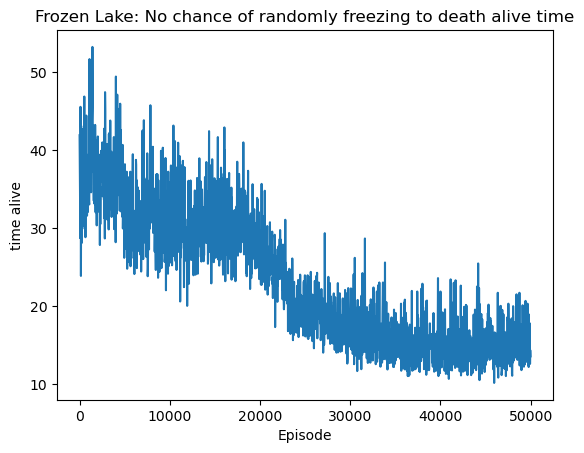

rewards_per_episode


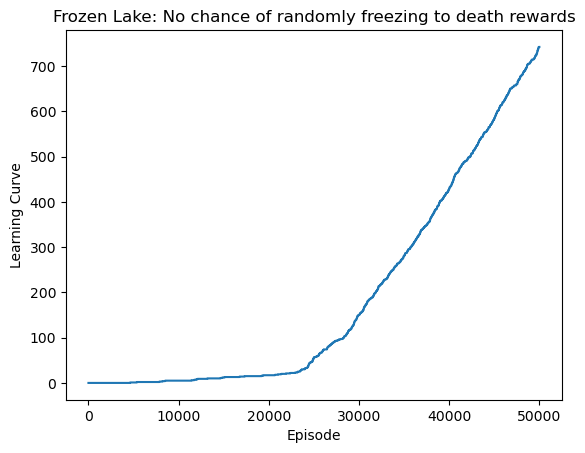

Iteration: 1000, Score: 6
Iteration: 2000, Score: 53
Iteration: 3000, Score: 43
Iteration: 4000, Score: 7
Iteration: 5000, Score: 26
Iteration: 6000, Score: 18
Iteration: 7000, Score: 54
Iteration: 8000, Score: 32
Iteration: 9000, Score: 9
Iteration: 10000, Score: 16
Iteration: 11000, Score: 17
Iteration: 12000, Score: 28
Iteration: 13000, Score: 31
Iteration: 14000, Score: 13
Iteration: 15000, Score: 41
Iteration: 16000, Score: 34
Iteration: 17000, Score: 34
Iteration: 18000, Score: 17
Iteration: 19000, Score: 8
Iteration: 20000, Score: 7
Iteration: 21000, Score: 24
Iteration: 22000, Score: 14
Iteration: 23000, Score: 1
Iteration: 24000, Score: 8
Iteration: 25000, Score: 6
Iteration: 26000, Score: 21
Iteration: 27000, Score: 17
Iteration: 28000, Score: 3
Iteration: 29000, Score: 31
Iteration: 30000, Score: 19
Iteration: 31000, Score: 18
Iteration: 32000, Score: 27
Iteration: 33000, Score: 13
Iteration: 34000, Score: 15
Iteration: 35000, Score: 19
Iteration: 36000, Score: 7
Iteration: 

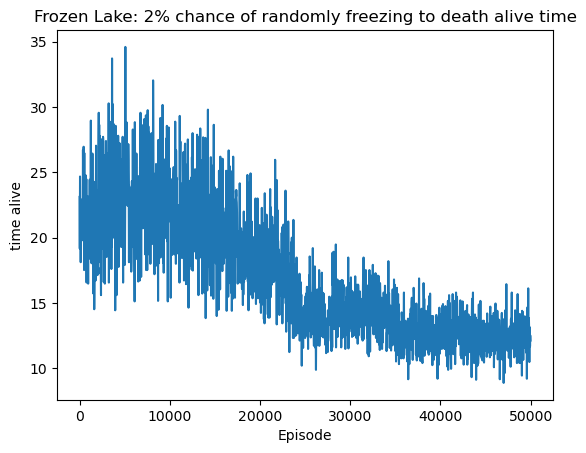

rewards_per_episode


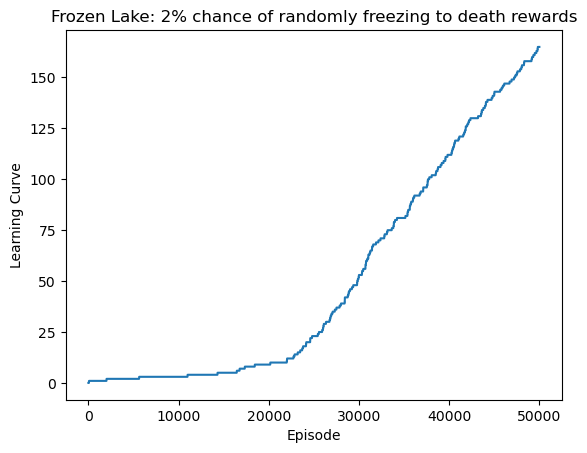

In [9]:
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map


def train_frozen_lake(two_percent_chance_randomly_freezing_to_death = False):
    agent = FrozenLakeAgent()
    time_alive = []
    total_amount_of_wins = [0]


    for iteration in range(1, total_iterations+1):
        steps = 0
        done = False
        state = env.reset()

        cumulative_reward = 0
        action_probabilities = []


        while not done:
            steps += 1
            
            
            action, action_prob = agent.act([state])
            action_probabilities.append(action_prob)



            state, reward, done, *_ = env.step(action)
            if two_percent_chance_randomly_freezing_to_death:
                if np.random.rand() < 0.02:
                    done = True

            cumulative_reward += reward
        if cumulative_reward == 1:
            total_amount_of_wins.append(total_amount_of_wins[-1] + 1)
        else:
            total_amount_of_wins.append(total_amount_of_wins[-1])
        policy_loss = [-log_prob * cumulative_reward for log_prob in action_probabilities]
        policy_loss = torch.cat(policy_loss).sum()

        agent.optimizer.zero_grad()
        policy_loss.backward()
        agent.optimizer.step()

        time_alive.append(steps)
        if iteration % logging_interval == 0:
            print("Iteration: {}, Score: {}".format(iteration, steps))

        
    x = np.arange(1, len(time_alive),25)
    y = np. add.reduceat(time_alive,x) / 25

    sns.lineplot(x=x, y=y)
    plt.xlabel("Episode")
    plt.ylabel("time alive")
    if two_percent_chance_randomly_freezing_to_death:
        plt.title("Frozen Lake: 2% chance of randomly freezing to death alive time")
        plt.savefig("Frozen_Lake_2_percent_time_alive.png")
    else:
        plt.title("Frozen Lake: No chance of randomly freezing to death alive time")
        plt.savefig("Frozen_Lake_no_chance_time_alive.png")
    plt.show()

    x = np.array(range(1, len(total_amount_of_wins)+1))
    print("rewards_per_episode")
    y = np.array(total_amount_of_wins)

    sns.lineplot(x=x, y=y)
    plt.xlabel("Episode")
    plt.ylabel("Learning Curve / Total Rewards ")
    if two_percent_chance_randomly_freezing_to_death:
        plt.title("Frozen Lake: 2% chance of randomly freezing to death rewards")
        plt.savefig("Frozen_Lake_2_percent_rewards.png")
    else:
        plt.title("Frozen Lake: No chance of randomly freezing to death rewards")
        plt.savefig("Frozen_Lake_no_chance_rewards.png")
    plt.show()

    




total_iterations = 50000
logging_interval = 1000
env = gym.wrappers.RecordVideo(gym.make('FrozenLake-v1', desc=generate_random_map(size=8)),
                                video_folder="./videos",
                                episode_trigger=lambda x: x == total_iterations - 1)

train_frozen_lake(two_percent_chance_randomly_freezing_to_death = False)
train_frozen_lake(two_percent_chance_randomly_freezing_to_death = True)